In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from imblearn.over_sampling  import SMOTE
import xgboost
from sklearn.utils import class_weight
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout, Input, Embedding, Reshape, Concatenate, Activation, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping
import time

Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('data_wth_outliners_plus.csv')
raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
raw_data.head()

,Unnamed: 0.1,Nombre pieces principales,Surface reelle bati,Valeur fonciere,Code postal,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degré de densité,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude
0,0.0,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333
1,1.0,3,87,43000,16700,1,2014,1,1,9611.0,18267.0,0.0,3.274,0.0,0.000,0.707,0.293,0.162,45.959
2,2.0,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333
3,3.0,4,74,73000,9220,1,2014,1,2,1157.0,18233.0,0.0,3.086,0.0,0.000,0.865,0.135,1.564,42.764
4,4.0,5,92,150000,80500,1,2014,1,2,12900.0,18641.0,0.0,2.698,0.0,0.450,0.354,0.197,2.567,49.650


In [3]:
df = raw_data.copy()

In [56]:

inputs_stdsc =df_test[['Valeur fonciere', 'Code type local',
                        'year', 'month', 'day', 'P15_POP', 'MED14','Part population dense (1)',
                        'Part population intermédiaire (2)', 'Part population peu dense (3)',
                        'Part population très peu dense (4)', 'Longitude', 'Latitude']].values
inputs_mmsc = df_test[['Surface reelle bati','nombre de redevables','Typo degré de densité']].values

In [57]:
sc = StandardScaler()
mms= MinMaxScaler()
inputs_stdsc = sc.fit_transform(inputs_stdsc)
inputs_mmsc = mms.fit_transform(inputs_mmsc)

In [58]:
targets = inputs_mmsc[:,0]

In [59]:
scaled_values = np.concatenate((inputs_mmsc[:,1:],inputs_stdsc), axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(scaled_values, targets, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(1/9), random_state=42)

In [61]:
def NN_model(hidden_layers,size_hl): 
    inputs = Input(shape=(X_train.shape[1],))
    for hidden_layer in range(hidden_layers):
        if hidden_layer==1:
            x = Dense(int(size_hl*(1.75)), activation='linear')(inputs)
            x = Activation(LeakyReLU(0.05))(x)
            x = Dropout(.1)(x)
            x = BatchNormalization()(x)
        elif hidden_layer>1:
            if hidden_layer%2==0:
                x = Dense(int(size_hl*(1.5)), activation='linear')(x)
                x = Activation(LeakyReLU(0.05))(x)
                x = Dropout(.1)(x)
                x = BatchNormalization()(x)
            elif hidden_layer%2==1:
                x = Dense(int(size_hl*0.5), activation='linear')(x)
                x = Activation(LeakyReLU(0.05))(x)
                x = Dropout(.1)(x)
                x = BatchNormalization()(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
        

In [62]:
model = NN_model(hidden_layers=2, size_hl=200)


model.fit(X_train,y_train,
          epochs=3, batch_size=32,validation_data=(X_val,y_val),
          verbose=1)

C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 2409246 samples, validate on 301156 samples
Epoch 1/3
2409246/2409246 [==============================] - 256s 106us/step - loss: 7.0586e-04 - val_loss: 5.1413e-04
Epoch 2/3
2409246/2409246 [==============================] - 267s 111us/step - loss: 5.2902e-04 - val_loss: 5.0901e-04
Epoch 3/3
2409246/2409246 [==============================] - 260s 108us/step - loss: 5.2764e-04 - val_loss: 5.0476e-04


In [63]:
y_pred = model.predict(X_test)

C:\Users\cmorv\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


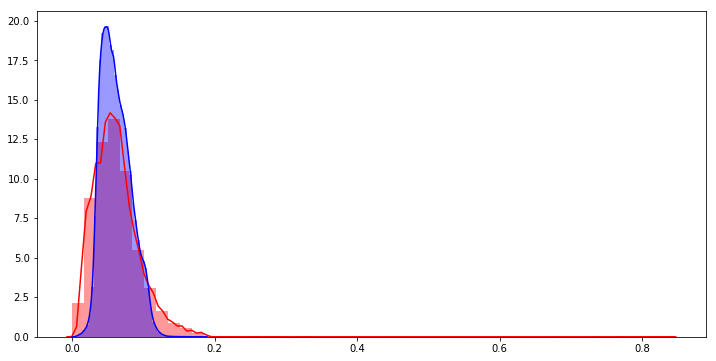

In [64]:
plt.figure(figsize=(12,6))
sns.distplot(y_test, color='red')
sns.distplot(y_pred, color='blue')

In [23]:
df['€/m2'] = df['Valeur fonciere']/df['Surface reelle bati']

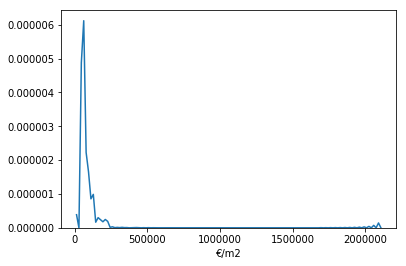

In [28]:
sns.distplot(df[df['€/m2']>20000]['€/m2'], hist=False)

In [32]:
df[df['€/m2']>20000]['Code postal'].value_counts()

92150    1307
33000     777
59800     766
75018     717
75020     621
59000     620
75017     539
78300     524
31000     507
34090     501
93300     497
31100     492
75019     448
51100     447
75016     446
76000     439
95100     422
75010     417
44000     401
75011     385
13002     373
33260     367
6200      353
75006     350
93400     350
69003     343
69100     339
69008     338
95210     333
63000     332
         ... 
56950       1
84580       1
59920       1
6670        1
88550       1
24550       1
80170       1
59600       1
41210       1
86340       1
35580       1
31330       1
61110       1
65170       1
13640       1
77710       1
21700       1
16300       1
87140       1
73800       1
24800       1
49460       1
17380       1
38590       1
59440       1
16390       1
76360       1
53140       1
44760       1
9700        1
Name: Code postal, Length: 2263, dtype: int64

In [34]:
print(len(df[df['Code postal']==33000]))
print(len(df[(df['€/m2']>20000)&(df['Code postal']==33000)]))

9533
777


In [35]:
df[(df['€/m2']>20000)&(df['Code postal']==75001)]

,Unnamed: 0.1,Nombre pieces principales,Surface reelle bati,Valeur fonciere,Code postal,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degré de densité,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,€/m2
27696,28635.0,1,20,460000,75001,2,2014,1,21,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,23000.000000
30992,31987.0,2,37,1214000,75001,2,2014,1,22,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,32810.810811
111299,116207.0,1,26,540400,75001,2,2014,2,26,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,20784.615385
111311,116219.0,2,26,540400,75001,2,2014,2,26,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,20784.615385
193952,203110.0,2,28,619300,75001,2,2014,4,3,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,22117.857143
203495,213125.0,4,104,2526750,75001,2,2014,4,10,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,24295.673077
205411,215175.0,4,104,2784750,75001,2,2014,4,11,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,26776.442308
210573,220455.0,1,44,950000,75001,2,2014,4,14,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,21590.909091
245887,257316.0,1,13,1275000,75001,2,2014,4,30,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,98076.923077
245888,257317.0,2,63,1275000,75001,2,2014,4,30,16545.0,31574.0,833.0,1.0,1.0,0.0,0.0,0.0,2.342,48.859,20238.095238


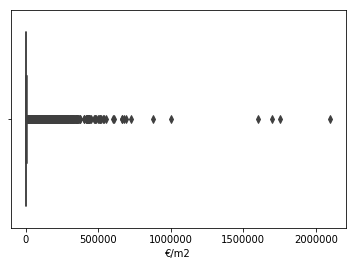

In [39]:
sns.boxplot(df['€/m2'])

In [44]:
a = df[df['€/m2']>20000]['€/m2'].median()

In [45]:
df_suite = df[df['€/m2']<a]

In [50]:
df_suite.drop(['Unnamed: 0.1'], axis=1, inplace=True)

C:\Users\cmorv\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [51]:
df_suite[df_suite['€/m2']>20000].head()

,Nombre pieces principales,Surface reelle bati,Valeur fonciere,Code postal,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degré de densité,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,€/m2
243,4,89,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.0,0.092,0.863,0.045,-1.011,46.11,26966.292135
244,3,74,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.0,0.092,0.863,0.045,-1.011,46.11,32432.432432
245,4,102,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.0,0.092,0.863,0.045,-1.011,46.11,23529.411765
246,3,74,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.0,0.092,0.863,0.045,-1.011,46.11,32432.432432
247,4,102,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.0,0.092,0.863,0.045,-1.011,46.11,23529.411765


In [54]:
df_suite[df_suite['Valeur fonciere']==2400000]

,Nombre pieces principales,Surface reelle bati,Valeur fonciere,Code postal,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degré de densité,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,€/m2
243,4,89,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.000,0.092,0.863,0.045,-1.011,46.110,26966.292135
244,3,74,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.000,0.092,0.863,0.045,-1.011,46.110,32432.432432
245,4,102,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.000,0.092,0.863,0.045,-1.011,46.110,23529.411765
246,3,74,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.000,0.092,0.863,0.045,-1.011,46.110,32432.432432
247,4,102,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.000,0.092,0.863,0.045,-1.011,46.110,23529.411765
248,4,90,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.000,0.092,0.863,0.045,-1.011,46.110,26666.666667
259,4,102,2400000,17220,1,2014,1,2,23543.0,21944.0,0.0,2.907,0.000,0.092,0.863,0.045,-1.011,46.110,23529.411765
14501,5,200,2400000,6250,1,2014,1,13,18476.0,24480.0,0.0,2.000,0.311,0.627,0.059,0.003,7.004,43.599,12000.000000
14502,5,200,2400000,6250,1,2014,1,13,18476.0,24480.0,0.0,2.000,0.311,0.627,0.059,0.003,7.004,43.599,12000.000000
82901,4,161,2400000,1220,1,2014,2,17,11115.0,39799.0,0.0,2.071,0.000,0.816,0.175,0.009,6.117,46.330,14906.832298


In [55]:
df_test=df_suite[df_suite['€/m2']<22000]

In [66]:
df_test.to_csv('final_wth_outliners_plus.csv')